<h1 align="center" style="font-variant: small-caps">How to build a genome-scale cell growth model</h1>
<h2 align="center">TUTORIAL 1 &mdash; Collect data</h2>
<h5 align="center">(<code>Version 13</code>, June 2025)</h5>

<div align="center" style="max-width:100px;display:block;margin:auto;">

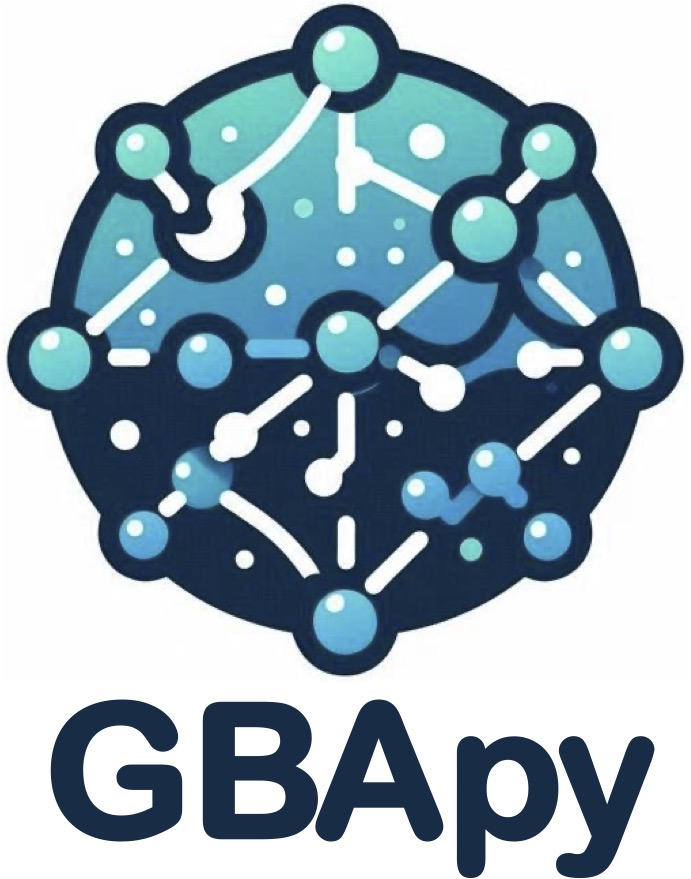

</div>

# Table of contents <a id="table_of_contents"></a>

- [1. Introduction](#introduction)
- [2. Create the cell growth model (CGM) builder](#cgm_builder)
- [3. Load proteins](#proteins)
  - [3.1. Load the proteins from the genome assembly](#proteins_1)
  - [3.2. Calculate average protein and dummy protein for spontaneous reactions](#proteins_2)
- [4. Load metabolites](#metabolites)
  - [4.1. Load metabolites from the SBML model](#metabolites_1)
  - [4.2. Load tRNAs](#metabolites_2)
  - [4.3. Manually curate missing molecular masses](#metabolites_3)
- [5. Load reactions](#reactions)
  - [5.1. Collect information from the SBML file](#reactions_1)
  - [5.2. Load the enzyme composition](#reactions_2)
  - [5.3. Add pseudo-proteins to reactions with missing annotation](#reactions_3)
  - [5.4. Edit the boundaries of reactions connected to exchange reactions with specific boundaries](#reactions_4)
- [6. Load kinetic parameters](#kinetics)
  - [6.1. (optional) Generate tables for kinetic parameters predition](#kinetics_1)
  - [6.3. Load predicted $k_\text{cat}$ values](#kinetics_2)
  - [6.4. Complete with default $k_\text{cat}$ values](#kinetics_3)
  - [6.6. Load predicted $K_\text{M}$ values](#kinetics_4)
  - [6.7. Complete with default $K_\text{M}$ values](#kinetics_5)
- [7. Model builder summary](#summary)
- [8. Reconstruct the FBA model](#FBA)
  - [8.1. Define a biomass function](#FBA_1)
  - [8.2. Build the FBA model and compare with the original model](#FBA_2)
- [9. Backup the CGM builder](#save)

# In summary

<div align="center" style="max-width:350px;display:block;margin:auto;">

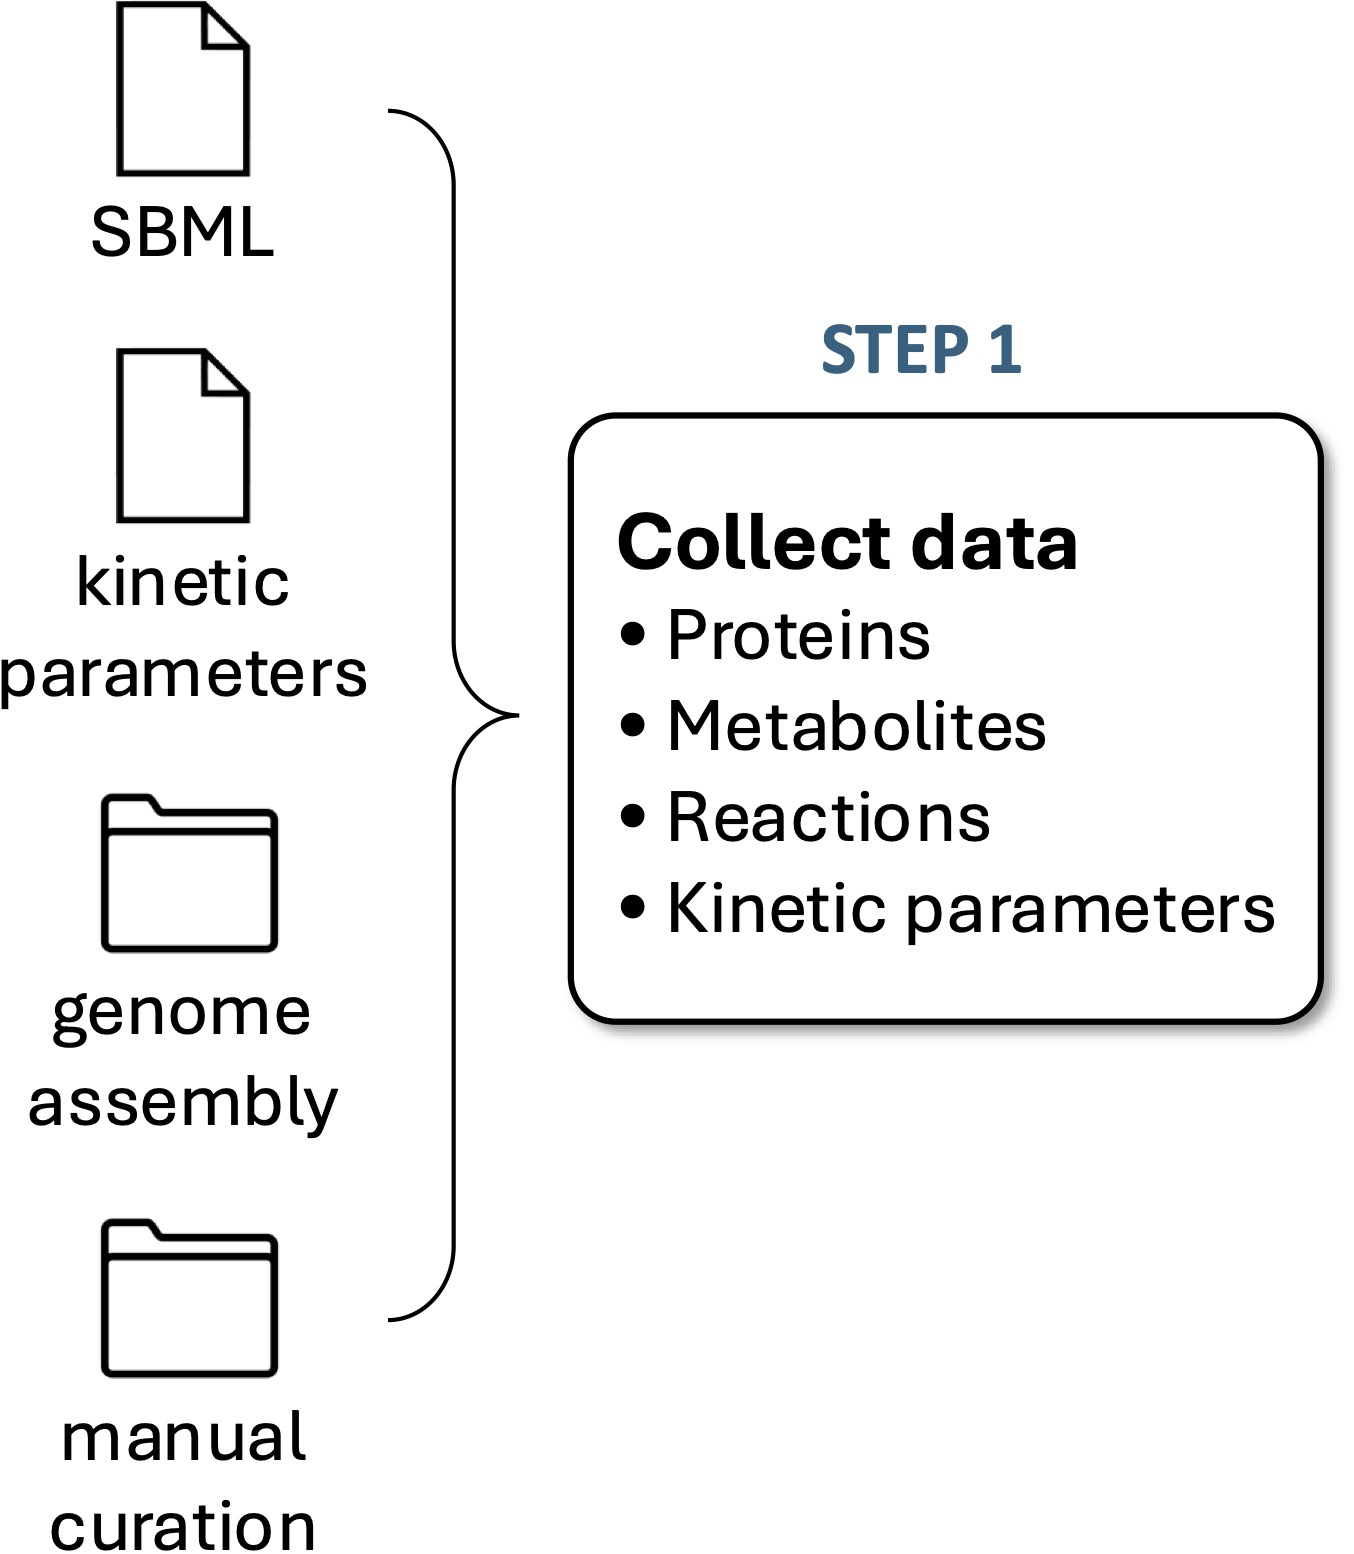

</div>

<div align="center">
<br/><br/>
<strong>&rarr; At each step of this tutorial, the GBApy methods used are listed</strong>.
</div>

# 1. Introduction <a id="introduction"></a>

[&#10148; Back to the table of contents](#table_of_contents)

In this walkthrough tutorial, we will use the minimal cell synthetic organism [(Moger-Reischer et al. 2023)](https://www.nature.com/articles/s41586-023-06288-x) to build a functional genome-scale cell growth model (CGM). We will rely on the FBA model of a minimal cell published by [Breuer et al. (2019)](https://elifesciences.org/articles/36842), and annotated by us (located in `./tutorials/MMSYN_tutorial/data/manual_curation/MMSYN_annotated.xml`).

We will need the last version of the minimal cell genome assembly available on [the NCBI database](https://www.ncbi.nlm.nih.gov/datasets/genome/GCA_001708325.2/), and various datasets collected and compiled here:
- The enzyme composition (`./tutorials/MMSYN_tutorial/data/manual_curation/MMSYN_enzyme_composition.csv`);
- Manually curated molecular weights (see below).

To this aim, we will deploy our Python package <strong>GBApy</strong> (https://github.com/charlesrocabert/gbapy).

For curious readers, an online database is also available for the minimal cell model: https://synwiki.uni-goettingen.de/v1/index.php.

But first, let's import the necessary Python modules:
- `gba`: Our <strong>GBApy</strong> module dedicated to CGM building;
- `cobra`: COBRApy module, dedicated to constraint-based modeling (https://opencobra.github.io/cobrapy/);
- `numpy`: a Python framework for mathematical and linear algebra calculation (https://numpy.org/);
- `pandas`: a Python module to manipulate data (https://pandas.pydata.org/);
- `Bio`: a set of freely available tools for biological computation (https://biopython.org/).

In [1]:
import gba
import cobra
import numpy as np
import pandas as pd
from Bio import SeqIO

# 2. Creating the cell growth model (CGM) builder <a id="cgm_builder"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder( name )</code> | Constructor of the class <code>gba.Builder</code> |

</div>

This is the main <strong>GBApy</strong> class we will use to build the genome-scale CGM of a minimal cell. We also load the annotated SBML model of a minimal cell using [COBRApy](https://opencobra.github.io/cobrapy/).

In [2]:
builder    = gba.Builder("GBA_MMSYN")
sbml_model = cobra.io.read_sbml_model("data/manual_curation/MMSYN_annotated.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-15


# 3. Load proteins <a id="proteins"></a>

[&#10148; Back to the table of contents](#table_of_contents)

## 3.1. Load proteins from the genome assembly <a id="proteins_1"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Protein( id, name, sequence, mass, gene, product )</code> | Constructor of the class <code>gba.Protein</code> |
| <code>gba.Protein.calculate_mass()</code> | Calculate the mass of a protein based on its amino-acid sequence |
| <code>gba.Builder.add_protein( protein )</code> | Add a protein to the CGM builder |
| <code>gba.Builder.detect_missing_mass( verbose )</code> | Detect and display elements with missing molecular mass |
| <code>gba.Protein.summary()</code> | Display a summary of a protein |

</div>

To load proteins, we will parse the Fasta file containing translated coding sequences (CDS), using the Python module `Bio`.

<strong>&#9888; Due to variations in Fasta record attributes, this has to be done manually.</strong>

In [3]:
builder.proteins.clear()
translated_CDS_file = SeqIO.parse(open("data/ASM170832v2/GCA_001708325.2_ASM170832v2_translated_cds.faa", "r"), "fasta")
for record in translated_CDS_file:
    # Parse the FASTA record
    gene_id      = None
    protein_id   = None
    product      = None
    protein_name = None
    sequence     = None
    if "[gene=" in record.description:
        gene_id = record.description.split("[gene=")[1].split("]")[0]
    if "[locus_tag=" in record.description:
        protein_id = "protein"+record.description.split("[locus_tag=")[1].split("]")[0].replace("JCVISYN3A", "")
    if "[protein=" in record.description:
        product = record.description.split("[protein=")[1].split("]")[0]
    if "[protein_id=" in record.description:
        protein_name = record.description.split("[protein_id=")[1].split("]")[0]
    sequence = str(record.seq).replace("*", "")
    # Create a new protein and add it to the builder
    if protein_id != None and sequence != None:
        protein = gba.Protein(id=protein_id, name=protein_name, sequence=sequence, gene=gene_id, product=product)
        protein.calculate_mass()
        builder.add_protein(protein)

We now check that all the proteins included in the SBML model have been colected through the genome assembly:

In [4]:
for gene in sbml_model.genes:
    protein_id = "protein_"+gene.id.split("_")[-1]
    assert protein_id in builder.proteins

We also check that no molecular mass is left uncalculated:

In [5]:
missing = builder.detect_missing_mass(verbose=True)

❯ Info,No missing mass in the model.


Here is an example of a protein loaded in the model (the protein `0599`, https://synwiki.uni-goettingen.de/v1/gene?id=1e850f26fa27826b75abe2e144c7877a43949e4e):

In [6]:
builder.proteins["protein_0599"].summary()

,protein_0599
Name,AVX54863.1
Location,Internal
Type,Protein
Formula,MKDNNSRFIPWDSISEEELL...
Mass,5530.2461


In [7]:
# Some statistics are displayed for the manuscript
avg_mass = 0.0
for protein in builder.proteins.values():
    avg_mass += protein.mass
avg_mass /= len(builder.proteins)
print("> Number of proteins: %d" % len(builder.proteins))
print("> Average protein mass: %.2f Da" % avg_mass)

# Data saved for supplementary material
builder.write_proteins_list(path="./output", name="JCVISYN3A")

> Number of proteins: 458
> Average protein mass: 39937.60 Da


## 3.2. Calculate an average protein and a dummy protein for spontaneous reactions <a id="proteins_2"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.create_average_protein( id, name, protein_list )</code> | Create an average protein based on a list of protein IDs |
| <code>gba.Builder.create_dummy_protein( id, name, mass )</code> | Create a dummy protein with a given mass |

</div>

We will now create two pseudo-proteins:

- An <strong>average protein</strong>, which will be used to attribute an enzyme to reactions with unknown annotation;
- A <strong>dummy protein</strong> with a weight of 1 Dalton for spontaneous reactions, which also do not have an enzyme composition.

Methods are available into <strong>GBApy</strong> for this task:

In [8]:
# Create average protein for reactions with missing annotation
builder.create_average_protein("average_protein", "Average protein", [protein.id for protein in builder.proteins.values()])
builder.proteins["average_protein"].summary()

# Create light dummy protein for spontaneous reactions
builder.create_dummy_protein("spontaneous_protein", "Dummy protein for spontaneous reactions", 1.0)
builder.proteins["spontaneous_protein"].summary()

❯ Info,Created average protein average_protein (39937.6 Da).


,average_protein
Name,Average protein
Location,Internal
Type,Protein
Formula,-
Mass,39937.604726


❯ Info,Created dummy protein spontaneous_protein (1.0 Da).


,spontaneous_protein
Name,Dummy protein for spontaneous reactions
Location,Internal
Type,Protein
Formula,-
Mass,1.0


# 4. Load metabolites<a id="metabolites"></a>

[&#10148; Back to the table of contents](#table_of_contents)

We will now parse the SBML model to collect as much information as we can on metabolites.

To calculate the molecular masses, we must consider different types of molecules:
- <strong>Small molecules</strong>, for which the mass is directly calculated from the chemical formula,
- <strong>tRNAs</strong>, for which the sequence must be collected from the genome assembly,
- <strong>Macro-molecules</strong>, where manual curation is required.

## 4.1. Load metabolites from the SBML model <a id="metabolites_1"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.SpeciesLocation</code> | Define the location of a species (internal, external or unknown) |
| <code>gba.SpeciesType</code> | Define the type of a species (DNA, RNA, Protein, small molecule, macro-molecule, unknown) |
| <code>gba.Metabolite(id, name, species_location, species_type, formula, annotation )</code> | Constructor of the class <code>gba.Metabolite</code> |
| <code>gba.Metabolite.calculate_mass()</code> | Calculate the mass of a metabolite |
| <code>gba.Builder.add_metabolite( metabolite )</code> | Add a metabolite to the CGM builder |
| <code>gba.Metabolite.summary()</code> | Display a summary of the metabolite |

</div>

For each metabolite, it is required to specify the location (internal/external) and the type (small molecule, RNA, DNA or macro-molecule):
- For the location, we use <strong>GBApy</strong> categories `SpeciesLocation.Internal` and `SpeciesLocation.External`,
- For the type, we use <strong>GBApy</strong> categories `SpeciesType.SmallMolecule`, `SpeciesLocation.MacroMolecule`, `SpeciesLocation.DNA`, `SpeciesLocation.RNA` or `SpeciesLocation.Unknown`.

The choice of the molecular category will depend on JCVI-syn3A model's nomenclature:
- `..._c`: internal metabolite,
- `e_...`: external metabolite,
- `trna` included in the ID: uncharged/charged tRNA,
- `dna` included in the ID: DNA molecule,
- Radical `R` present in the chemical formula: macro-molecule.

<strong>&#9888; Due to variations in the SBML nomenclature, automation is not possible here.</strong>

In [9]:
builder.metabolites.clear()
for compound in sbml_model.metabolites:
    # Create the metabolite
    location   = (gba.SpeciesLocation.External if compound._id.endswith("_e") else gba.SpeciesLocation.Internal)
    annotation = compound.annotation
    metabolite = gba.Metabolite(id=compound._id, name=compound.name,
                                species_location=location, species_type=gba.SpeciesType.Unknown,
                                formula=compound.formula, annotation=annotation)
    # Define molecular category if known
    if "trna" not in compound._id and "R" not in compound.formula:
        metabolite.species_type = gba.SpeciesType.SmallMolecule
        metabolite.calculate_mass()
        if compound.id == "DNA_c":
            metabolite.species_type = gba.SpeciesType.DNA
        if compound.id == "RNA_c":
            metabolite.species_type = gba.SpeciesType.RNA
    # Add the metabolite to the builder
    builder.add_metabolite(metabolite)

Here is an example of a loaded metabolite with the metabolite NADP+:

In [10]:
builder.metabolites["nadp_c"].summary()

,nadp_c
Name,NADP+
Location,Internal
Type,Small molecule
Formula,C21H25N7O17P3
Mass,740.382157


## 4.2. Load tRNAs <a id="metabolites_2"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Metabolite(id, name, species_location, species_type, formula, annotation )</code> | Constructor of the class <code>gba.Metabolite</code> |
| <code>gba.Metabolite.calculate_mass()</code> | Calculate the mass of a metabolite |
| <code>gba.Builder.add_metabolite( metabolite )</code> | Add a metabolite to the CGM builder |
| <code>gba.Metabolite.summary()</code> | Display a summary of the metabolite |

</div>

We now need to parse the RNA Fasta file from the genome assembly to extract tRNA sequences, and finalize the calculation of their molecular masses.

<strong>&#9888; Once again, full automation is not possible here due to nomenclature variations. Some tRNAs also have duplicate sequences.</strong>

In [11]:
tRNAs    = {}
RNA_file = SeqIO.parse(open("data/ASM170832v2/GCA_001708325.2_ASM170832v2_rna_from_genomic.fna", "r"), "fasta")
# Collect tRNAs and manage duplicates
for record in RNA_file:
    if "[gene=tRNA-" in record.description:
        AA      = record.description.split("[gene=tRNA-")[1].split("]")[0].lower()
        tRNA_id = "trna"+AA
        tRNA    = gba.Metabolite(id=tRNA_id, species_type=gba.SpeciesType.RNA, formula=str(record.seq).replace("T", "U"))
        tRNA.calculate_mass()
        if AA in tRNAs:
            tRNAs[AA].mass  += tRNA.mass
            tRNAs[AA].count += 1
        else:
            tRNAs[AA]       = tRNA
            tRNAs[AA].count = 1
# Edit the model for uncharged/charged tRNAs
for AA in tRNAs:
    tRNAs[AA].mass /= tRNAs[AA].count
    uncharged_tRNA  = "trna"+AA+"_c"
    charged_tRNA    = AA+"trna_c"
    # Edit uncharged tRNAs
    assert uncharged_tRNA in builder.metabolites, f"{uncharged_tRNA} not in the list of metabolites"
    builder.metabolites[uncharged_tRNA].calculate_mass()
    builder.metabolites[uncharged_tRNA].species_type  = gba.SpeciesType.RNA
    builder.metabolites[uncharged_tRNA].formula       = tRNAs[AA].formula
    builder.metabolites[uncharged_tRNA].mass         += tRNAs[AA].mass
    # Edit charged tRNAs
    assert charged_tRNA in builder.metabolites, f"{charged_tRNA} not in the list of metabolites"
    builder.metabolites[charged_tRNA].calculate_mass()
    builder.metabolites[charged_tRNA].species_type  = gba.SpeciesType.RNA
    builder.metabolites[charged_tRNA].mass         += tRNAs[AA].mass

Here is an example of a loaded tRNA with the alanine carrier tRNA:

In [12]:
builder.metabolites["trnaala_c"].summary()

,trnaala_c
Name,TRNA(Ala)
Location,Internal
Type,RNA
Formula,GGGCCCUUAGCUCAGCUGGG...
Mass,24554.4967


## 4.3. Manually curate missing molecular masses <a id="metabolites_3"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.detect_missing_mass( verbose )</code> | Detect and display elements with missing molecular mass |

</div>

Metabolites with missing masses must now be curated manually. We see below that the molecular mass is missing for <strong>6.27%</strong> of all metabolites:

In [13]:
missing = builder.detect_missing_mass(verbose=True)

⚠ Warning,6.27% of metabolites with missing mass.


In [14]:
pd.DataFrame(missing["metabolites"], columns=["Missing mass"])

,Missing mass
0,12dgr_c
1,1ag3p_c
2,ACP_R_c
3,ap_c
4,cdpdag_c
5,clpn_c
6,fa_c
7,fa_e
8,fmettrna_c
9,galfur12dgr_c


For these metabolites, we have manually collected the molecular masses:

In [15]:
# Collect manually the molecular masses
manually_curated_molecular_masses = {
    "12dgr_c":       594.5350000000001,
    "1ag3p_c":       421.243,
    "ACP_R_c":       9187,
    "ap_c":          347.205,
    "cdpdag_c":      977.53,
    "clpn_c":        1403.015,
    "dnad_c":        662.08,
    "fa_c":          268.246,
    "fa_e":          268.246,
    "fmettrna_c":    25200,
    "galfur12dgr_c": 770,
    "glutrnagln_c":  25150,
    "lgltn_c":       14855.375,
    "pa_c":          672.4860000000001,
    "pg3p_c":        825.4830000000001,
    "pg_c":          747.532,
    "tag_c":         845.778,
    "tag_e":         845.778,
    "trdox_c":       11519.46,
    "trdrd_c":       11521.476
}

We check that no metabolite is left with uncalculated molecular mass:

In [16]:
# Complete missing molecular masses
for ID in manually_curated_molecular_masses:
    assert ID in builder.metabolites
    builder.metabolites[ID].mass         = manually_curated_molecular_masses[ID]
    builder.metabolites[ID].species_type = gba.SpeciesType.MacroMolecule

# Check that no metabolite has a missing mass
missing = builder.detect_missing_mass(verbose=True)

❯ Info,No missing mass in the model.


In [17]:
# Statistics are displayed for the manuscript
for aa, m in tRNAs.items():
    if m.count > 1:
        print("> Duplicate sequences for tRNA "+m.id+" (count = "+str(m.count)+", average mass = "+str(round(m.mass))+"Da)")

cat      = {}
avg_mass = 0.0
for m in builder.metabolites.values():
    avg_mass += m.mass
    if m.species_type not in cat:
        cat[m.species_type] = {"mass": 0.0, "kegg_coverage": 0.0, "count": 0}
    cat[m.species_type]["mass"] += m.mass
    if "kegg.compound" in m.annotation:
        cat[m.species_type]["kegg_coverage"] += 1
    cat[m.species_type]["count"] += 1
for s in cat:
    cat[s]["mass"] /= cat[s]["count"]
    cat[s]["kegg_coverage"] /= cat[s]["count"]
print("> Metabolite categories:")
for s in cat:
    print(f"  - {s.name}: {cat[s]['count']} metabolites, average mass {cat[s]['mass']:.2f} Da, KEGG coverage {cat[s]['kegg_coverage']:.2f}")
avg_mass /= len(builder.metabolites)
print("> Average metabolite mass: %.2f Da" % avg_mass)

# Data saved for supplementary material
builder.write_metabolites_list(path="./output", name="JCVISYN3A")

> Duplicate sequences for tRNA trnaleu (count = 3, average mass = 27734Da)
> Duplicate sequences for tRNA trnalys (count = 2, average mass = 24492Da)
> Duplicate sequences for tRNA trnaser (count = 2, average mass = 29594Da)
> Duplicate sequences for tRNA trnaarg (count = 2, average mass = 24890Da)
> Duplicate sequences for tRNA trnathr (count = 2, average mass = 24468Da)
> Duplicate sequences for tRNA trnatrp (count = 2, average mass = 24319Da)
> Duplicate sequences for tRNA trnamet (count = 3, average mass = 24701Da)
> Metabolite categories:
  - SmallMolecule: 241 metabolites, average mass 1456.42 Da, KEGG coverage 0.98
  - MacroMolecule: 20 metabolites, average mass 5354.12 Da, KEGG coverage 0.95
  - DNA: 1 metabolites, average mass 30781.09 Da, KEGG coverage 1.00
  - RNA: 41 metabolites, average mass 25286.93 Da, KEGG coverage 1.00
> Average metabolite mass: 5035.07 Da


# 5. Load reactions <a id="reactions"></a>

[&#10148; Back to the table of contents](#table_of_contents)

## 5.1. Collect information from the SBML file <a id="reactions_1"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.ReactionType</code> | Define the type of a reaction (transport, metabolic, exchange or unknown) |
| <code>gba.ReactionGPR</code> | Define the logic of the Gene-Protein-Reaction association (none, and, or) |
| <code>gba.Reaction(id, name, reaction_type, lb, ub, metabolites, proteins, GPR, enzyme_mass )</code> | Constructor of the class <code>gba.Reaction</code> |
| <code>gba.Builder.add_reaction( reaction )</code> | Add a reaction to the CGM builder |
| <code>gba.Reaction.summary()</code> | Display a summary of the reaction |

</div>

We will now parse the SBML model to collect as much information as we can on reactions.

We must distinguish transport from metabolic reactions, and exclude exchange and biomass reactions, which are specific to FBA modeling.

The enzyme composition will be collected afterward.

In [18]:
builder.reactions.clear()
for reaction in sbml_model.reactions:
    # Exclude unwanted reactions
    if reaction.id == "BIOMASS":
        continue
    if reaction.lower_bound == 0.0 and reaction.upper_bound == 0.0:
        continue
    if reaction.subsystem == "Exchange":
        continue
    # Define reaction type
    reaction_type = None
    if reaction.subsystem == "Transport":
        reaction_type = gba.ReactionType.Transport
    else:
        reaction_type = gba.ReactionType.Metabolic
    # Collect reaction's stoichiometry
    metabolites = {}
    for metabolite in reaction.metabolites:
        assert metabolite.id in builder.metabolites
        assert metabolite.id not in metabolites
        metabolites[metabolite.id] = reaction.metabolites[metabolite]
    # Collect GPR logic
    GPR = gba.ReactionGPR.NONE
    if "and" in str(reaction.gpr) and "or" not in str(reaction.gpr):
        GPR = gba.ReactionGPR.AND
    elif "or" in str(reaction.gpr) and "and" not in str(reaction.gpr):
        GPR = gba.ReactionGPR.OR
    # Create the reaction
    reaction = gba.Reaction(id=reaction.id, name=reaction.name, reaction_type=reaction_type,
                            lb=reaction.lower_bound, ub=reaction.upper_bound,
                            metabolites=metabolites, GPR=GPR)
    builder.add_reaction(reaction)

Here is an example of a loaded reaction with the Phosphoglycerate kinase reaction.

We see that information is missing (`-`) for:
- The enzyme mass;
- The enzyme composition in proteins ("Proteins");
- Kinetic parameters.

In [19]:
builder.reactions["Kt6"].summary()

,Kt6
Name,Kt6
Type,Transport
Stoichiometry,atp_c + h2o_c + k_e + na1_c --> adp_c + h_c + k_c + na1_e + pi_c
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,-
GPR,AND
Proteins,-
Forward kcat,-
Backward kcat,-


## 5.2. Load the enzyme composition <a id="reactions_2"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Reaction.add_proteins( protein )</code> | Add a protein and its stoichiometry to the enzyme composition of a reaction |
| <code>gba.Reaction.calculate_enzyme_mass()</code> | Calculate the enzyme's molecular mass based on the GPR |
| <code>gba.Reaction.summary()</code> | Display a summary of the reaction |

</div>

We have previously compiled the enzyme composition for other close organisms in a CSV file (`./data/manual_curation/MMSYN_enzyme_composition.csv`). We will now load it in the model.

To do so, we need to look for the GPR association of each reaction:
- In case of an `AND` association, the enzyme is multimeric, and all proteins are needed with given stoichiometries;
- In the case of an `OR` association, proteins relate to iso-enzymes. In this case, one approach is to select the most performant enzyme. The most effective enzyme will be the one with the lowest molecular weight $w$ and the highest number of active sites $s$. We therefore selected the protein with the lowest $\frac{w}{s}$ value.

In [20]:
f   = open("data/manual_curation/MMSYN_enzyme_composition.csv", "r")
l   = f.readline()
l   = f.readline()
GPR = {}
while l:
    l        = l.strip().split(";")
    r_id     = l[4][2:]
    comp     = l[1].split("|")
    s        = float(l[2])
    proteins = {}
    assert r_id in builder.reactions
    # Monomer or OR interaction
    if len(comp) == 1:
        elmt = comp[0]
        p_id = "protein_"+elmt.split(",")[0].split("_")[1]
        assert p_id in builder.proteins
        stoic = float(elmt.split(",")[1].split("=")[1])
        w     = builder.proteins[p_id].mass
        score = w/s
        if (r_id not in GPR) or (r_id in GPR and score < GPR[r_id]["score"]):
            GPR[r_id] = {"EC": {p_id: stoic}, "score": score}
    # Multimeric enzymes (AND interaction)
    elif len(comp) > 1:
        proteins = {}
        for elmt in comp:
            p_id  = "protein_"+elmt.split(",")[0].split("_")[1]
            stoic = float(elmt.split(",")[1].split("=")[1])
            assert p_id in builder.proteins
            proteins[p_id] = stoic
        builder.reactions[r_id].add_proteins(proteins)
        builder.reactions[r_id].calculate_enzyme_mass()
    l = f.readline()
f.close()
for r_id, gpr in GPR.items():
    builder.reactions[r_id].add_proteins(gpr["EC"])
    builder.reactions[r_id].calculate_enzyme_mass()

For example with the COA ABC transporter (`COAabc`), we see that four proteins are required (GPR = `AND`) to form the enzyme complex. The composition is given by the coefficients (<em>e.g.</em> 2 for protein `0641`).

The calculated enzyme mass is then 225725.1414 Da (in the case of a `OR` association, the average mass of proteins is calculated given the coefficients).

In [21]:
builder.reactions["COAabc"].summary()

,COAabc
Name,COA ABC transporter
Type,Transport
Stoichiometry,atp_c + coa_e + h2o_c --> adp_c + coa_c + h_c + pi_c
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,225725.1414
GPR,AND
Proteins,2.0 protein_0641 + 1.0 protein_0642 + 1.0 protein_0643 + 2.0 protein_0836
Forward kcat,-
Backward kcat,-


## 5.3. Add pseudo-proteins to reactions with missing annotation <a id="reactions_3"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.detect_missing_mass( verbose )</code> | Detect and display element with missing molecular mass |
| <code>gba.Reaction.add_proteins( protein )</code> | Add a protein to a reaction |
| <code>gba.Reaction.calculate_enzyme_mass()</code> | Calculate the enzyme's molecular mass based on the GPR |
| <code>gba.Reaction.summary()</code> | Display a summary of the reaction |

</div>

We will now use the pseudo-proteins created above to complete reactions with missing proteins (<strong>15.08%</strong> of all proteins):
- Transport reactions with no associated proteins are assumed to be spontaneous. A protein of mass 1 Da is attributed to the enzyme;
- The enzyme of metabolic reactions with no associated proteins is composed of one average protein.

In [22]:
missing = builder.detect_missing_mass(verbose=True)

⚠ Warning,15.08% of enzymes with missing mass.


In [23]:
pd.DataFrame(missing["enzymes"], columns=["Missing mass"])

,Missing mass
0,ACALDt
1,ACt
2,ADEt2
3,AMANabc
4,CHOLt
5,CLt
6,CO2t
7,CTPDP
8,DCDPMP
9,DCTPDP


In [24]:
# Add the light dummy protein to spontaneous transport reactions
for reaction in builder.reactions.values():
    if reaction.reaction_type == gba.ReactionType.Transport and reaction.enzyme_mass == None:
        reaction.add_proteins({"spontaneous_protein": 1.0})
        reaction.calculate_enzyme_mass()

# Add the average protein to unnanotated metabolic reactions
for reaction in builder.reactions.values():
    if reaction.reaction_type == gba.ReactionType.Metabolic and reaction.enzyme_mass == None:
        reaction.add_proteins({"average_protein": 1.0})
        reaction.calculate_enzyme_mass()

We check that all reactions are correctly parametrized:

In [25]:
missing = builder.detect_missing_mass(verbose=True)

❯ Info,No missing mass in the model.


As an example, we check that the pseudo-proteins have been allocated to water transport (spontaneous) and RNA production (RNAP):

In [26]:
builder.reactions["H2Ot"].summary()

,H2Ot
Name,H2O transport via diffusion
Type,Transport
Stoichiometry,h2o_e <=> h2o_c
Lower bound,-1000.0
Upper bound,1000.0
Enzyme mass,1.0
GPR,NONE
Proteins,1.0 spontaneous_protein
Forward kcat,-
Backward kcat,-


In [27]:
builder.reactions["RNAP"].summary()

,RNAP
Name,RNA polymerase reaction
Type,Metabolic
Stoichiometry,68.0 atp_c + 20.0 ctp_c + 25.0 gtp_c + 41.0 h2o_c + 28.0 utp_c --> RNA_c + 41.0 adp_c + 41.0 h_c + 41.0 pi_c + 100.0 ppi_c
Lower bound,0.0
Upper bound,1000.0
Enzyme mass,39937.604726
GPR,NONE
Proteins,1.0 average_protein
Forward kcat,-
Backward kcat,-


## 5.4. Edit the boundaries of reactions connected to exchange reactions with specific constraints <a id="reactions_4"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Reaction.lb</code> | Lower boundary of the reaction flux |
| <code>gba.Reaction.ub</code> | Upper boundary of the reaction flux |

</div>

Some boundary constraints in the original FBA model have been applied on exchange reactions instead of trasnport reactions.
We need to correct this for future FBA reconstruction.

In [28]:
edited_boundaries = {
    "ACt":      [-1000.0, 6.9],
    "ACALDt":   [0.0, 1000.0],
    "AMANabc":  [0.0, 0.0],
    "GAMpts":   [0.0, 0.0],
    "MANpts" :  [0.0, 0.0],
    "PYRt2r":   [0.0, 1000.0],
    "GLCpts":   [0.0, 7.4],
    "GLYCt":    [-1000.0, 0.193],
    "L_LACt2r": [0.0, 1000.0]
}
for item in edited_boundaries.items():
    assert item[0] in builder.reactions
    builder.reactions[item[0]].lb = item[1][0]
    builder.reactions[item[0]].ub = item[1][1]

In [29]:
# Data saved for supplementary material
builder.write_reactions_list(path="./output", name="JCVISYN3A")

# 6. Load kinetic parameters <a id="kinetics"></a>

[&#10148; Back to the table of contents](#table_of_contents)

We used DeepMolecules (https://esp.cs.hhu.de/) pre-trained functions to predict $k_\text{cat}$ and $K_\text{M}$ values. These functions require entries such as protein sequences and metabolite KEGG identifiers (https://www.genome.jp/kegg/pathway.html). Transporter annotations are typically missing, as well as a few reactions for which KEGG IDs are not available. Multiple predicted values are available when the enzyme composition involves more than one protein. We chose to select <strong>the maximal value</strong> for $k_\text{cat}$, and <strong>the minimal value</strong> for $K_\text{M}$, in order to reflect the fact that proteins leading to the most efficient catalytic rates are expected to carry the active site of the enzyme.
Default values are used to complete the model, as presented below.
When the reaction is irreversible, we enforce zero values for the backward direction. To do so, we will use the method `builder.enforce_kinetic_irreversibility()`.

Predicted kinetic parameters can be found in `./tutorials/MMSYN_tutorial/data/kinetic_parameters/predicted/`.

## 6.1. (optional) Generate tables for kinetic parameters prediction <a id="kinetics_1"></a>

[&#10148; Back to the table of contents](#table_of_contents)

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.generate_kinetic_parameter_tables()</code> | Generate kinetic parameter tables for machine learning predictions |

This optional step can be used to generate tables which can be directly used to predict kinetic parameters from DeepMolecules pre-trained functions (see https://esp.cs.hhu.de/). These tables, located in `./tutorials/MMSYN_tutorial/data/kinetic_parameters/tables/`, have been used to predict the $k_\text{cat}$ and $K_\text{M}$ used below.

In [30]:
builder.generate_kinetic_parameter_tables(path="./data/kinetic_parameters/tables")

## 6.2. Load predicted $k_\text{cat}$ values <a id="kinetics_2"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Reaction.add_kcat_value( direction, value )</code> | Add a $k_\text{cat}$ value to the reaction |
| <code>gba.Builder.enforce_kcat_irreversibility()</code> | Enforce the irreversibility of all reactions at the level of $k_\text{cat}$ values |
| <code>gba.Builder.detect_missing_kinetic_parameters( verbose )</code> | Detect and display reactions with missing kinetic parameters |

</div>

In [31]:
# Load kcat values predicted through machine learning
# (duplicates must be managed)
kcat_data = {}
f         = open("data/kinetic_parameters/predicted/kcat_predicted_values.csv", "r")
l         = f.readline().strip("\n").split("\t")
header    = {l[i]: i for i in range(len(l))}
l         = f.readline()
while l:
    l    = l.strip("\n").split("\t")
    r_id = l[header["reaction_id"]]
    dir  = l[header["direction"]]
    kcat = l[header["kcat"]]
    if kcat != "NA":
        kcat = float(kcat)*3600.0
        if r_id not in kcat_data:
            kcat_data[r_id] = {gba.ReactionDirection.Forward: [], gba.ReactionDirection.Backward: []}
        if dir == "forward":
            kcat_data[r_id][gba.ReactionDirection.Forward].append(kcat)
        elif dir == "backward":
            kcat_data[r_id][gba.ReactionDirection.Backward].append(kcat)
    l = f.readline()
f.close()

# Load the maximal kcat values into the model (exclude transporters)
for r_id in kcat_data:
    for dir in kcat_data[r_id]:
        if r_id in builder.reactions and len(kcat_data[r_id][dir]) > 0 and builder.reactions[r_id].has_missing_kcat_value() and builder.reactions[r_id].reaction_type != gba.ReactionType.Transport:
            builder.reactions[r_id].add_kcat_value(dir, np.max(kcat_data[r_id][dir]))

# Check for missing kinetic parameters
missing = builder.detect_missing_kinetic_parameters(verbose=True)

⚠ Warning,"63.10% of reactions with missing kcat values (100.00% transporters, 43.98% metabolic)."


⚠ Warning,100.00% of reactions with missing KM values.


We see that <strong>63.10%</strong> of the reactions have missing $k_\text{cat}$ (backward or forward) values: 100% of the transporters, and 43.98% of metabolic reactions (we expect 100% of missing $K_\text{M}$ values since we did not load them yet).

We now enforce the irreversibility of the reactions at the level of $k_\text{cat}$ values (<em>i.e.</em> if the reaction is forward irreversible, the backward $k_\text{cat}$ must be zero, and vice-versa).

In [32]:
# Enforce irreversibility of kcat values
builder.enforce_kcat_irreversibility()

## 6.3. Complete with default $k_\text{cat}$ values <a id="kinetics_3"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.detect_missing_kinetic_parameters( verbose )</code> | Detect and display reactions with missing kinetic parameters |
| <code>gba.Reaction.has_missing_kcat_value( )</code> | Indicate if $k_\text{cat}$ values are missing in the reaction |
| <code>gba.Reaction.complete_kcat_values( value )</code> | Fill missing $k_\text{cat}$ values with a given value |

</div>

Missing $k_\text{cat}$ values are completed with default values as following:

- For metabolic reactions, the default value is $k_\text{cat} = 45000.0\ h^{-1}$
- For spontaneous transporters (no associated GPR), the default value is $k_\text{cat} = 1 \times 10^{10}\ h^{-1}$
- For transporters with an associated enzyme, the default value is $k_\text{cat} = 360000.0\ h^{-1}$.

In [33]:
for reaction in builder.reactions.values():
    if reaction.has_missing_kcat_value() and reaction.reaction_type == gba.ReactionType.Metabolic:
        reaction.complete_kcat_values(45000)
    elif reaction.has_missing_kcat_value() and reaction.reaction_type == gba.ReactionType.Transport and "spontaneous_protein" in reaction.proteins:
        reaction.complete_kcat_values(1e+10)
    elif reaction.has_missing_kcat_value() and reaction.reaction_type == gba.ReactionType.Transport and "spontaneous_protein" not in reaction.proteins:
        reaction.complete_kcat_values(360000)
    
missing = builder.detect_missing_kinetic_parameters(verbose=True)

⚠ Warning,100.00% of reactions with missing KM values.


We have completed the loading of $k_\text{cat}$ values into the model builder.

## 6.4. Load predicted $K_\text{M}$ values <a id="kinetics_4"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Reaction.add_km_value( metabolite, value )</code> | Add a $K_\text{M}$ value for a (reaction, metabolite) pair |
| <code>gba.Builder.enforce_km_irreversibility()</code> | Enforce the irreversibility of all reactions at the level of $K_\text{M}$ values |
| <code>gba.Builder.detect_missing_kinetic_parameters( verbose )</code> | Detect and display reactions with missing kinetic parameters |

</div>

In [34]:
# Load KM values predicted through machine learning
# (duplicates must be managed)
KM_data = {}
f       = open("data/kinetic_parameters/predicted/KM_predicted_values.csv", "r")
l       = f.readline().strip("\n").split("\t")
header  = {l[i]: i for i in range(len(l))}
l       = f.readline()
while l:
    l    = l.strip("\n").split("\t")
    r_id = l[header["reaction_id"]]
    m_id = l[header["metabolite_id"]]
    KM   = l[header["KM"]]
    if KM != "NA":
        if r_id not in KM_data:
            KM_data[r_id] = {}
        if m_id not in KM_data[r_id]:
            KM_data[r_id][m_id] = []
        KM_data[r_id][m_id].append(float(KM))
    l = f.readline()
f.close()

# Load the minimal KM values into the model
for r_id in KM_data:
    for m_id in KM_data[r_id]:
        if r_id in builder.reactions and m_id in builder.metabolites and len(KM_data[r_id][m_id]) > 0 and builder.reactions[r_id].has_missing_km_value() and builder.reactions[r_id].reaction_type != gba.ReactionType.Transport:
            builder.reactions[r_id].add_km_value(m_id, np.min(KM_data[r_id][m_id]))

# Check for missing kinetic parameters
missing = builder.detect_missing_kinetic_parameters(verbose=True)

⚠ Warning,63.89% of reactions with missing KM values.


We see below that <strong>63.89%</strong> of the reactions have missing (backward or forward) $K_\text{M}$ values.

We now enforce the irreversibility of the reaction at the level of $K_\text{M}$ values (<em>i.e.</em> if the reaction is forward irreversible, products have a zero $K_\text{M}$ value, and vice-versa).

In [35]:
# Enforce irreversibility of KM values
builder.enforce_km_irreversibility()

## 6.5. Complete with default $K_\text{M}$ values <a id="kinetics_5"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Reaction.add_km_value( metabolite, value )</code> | Add a $K_\text{M}$ value for a (reaction, metabolite) pair |
| <code>gba.Builder.enforce_km_irreversibility()</code> | Enforce the irreversibility of all reactions at the level of $K_\text{M}$ values |
| <code>gba.Builder.detect_missing_kinetic_parameters( verbose )</code> | Detect and display reactions with missing kinetic parameters |
| <code>gba.Reaction.has_missing_km_value( )</code> | Indicate if $K_\text{M}$ values are missing in the reaction |
| <code>gba.Reaction.complete_km_values( value )</code> | Fill missing $K_\text{M}$ values with a given value |

</div>

Missing $K_\text{M}$ values are completed with default values as following:
- For spontaneous transporters (no associated GPR), the default value is $K_\text{M} = 1 \times 10^{-10}\ M$
- For other reactions, the default value is $K_\text{M} = 1.3 \times 10^{-4}\ M$

In [36]:
for reaction in builder.reactions.values():
    if reaction.has_missing_km_value() and "spontaneous_protein" in reaction.proteins:
        reaction.complete_km_values(1e-10)
    elif reaction.has_missing_km_value() and "spontaneous_protein" not in reaction.proteins:
        reaction.complete_km_values(0.00013)

missing = builder.detect_missing_kinetic_parameters(verbose=True)

❯ Info,No missing kinetic parameters in the model.


In [37]:
# Data saved for supplementary material
builder.write_kinetic_parameters_list(path="./output", name="JCVISYN3A") 

We have completed the loading of $K_\text{M}$ values into the model builder.

# 7. Model builder summary <a id="summary"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.summary()</code> | Display a summary of the CGM builder |

</div>

One can check the content of the model using the `summary()` method:

In [38]:
builder.summary()

CGM build GBA_MMSYN summary General 
 
 
 Category 
 Count 
 
 
 
 
 Proteins 
 460 
 
 
 Metabolites 
 303 
 
 
 Reactions 
 252 
 
 
 Metabolites 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Small molecules 
 241 
 79.54% 
 
 
 Macro-molecules 
 20 
 6.60% 
 
 
 DNA(s) 
 1 
 0.33% 
 
 
 RNA(s) 
 41 
 13.53% 
 
 
 Proteins 
 0 
 0.00% 
 
 
 Unknown 
 0 
 0.00% 
 
 
 Reaction types 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Metabolic 
 166 
 65.87% 
 
 
 Transport 
 86 
 34.13% 
 
 
 Exchange 
 0 
 0.00% 
 
 
 Reaction directions 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Forward 
 191 
 75.79% 
 
 
 Backward 
 1 
 0.40% 
 
 
 Reversible 
 60 
 23.81%

# 8. Reconstruct the FBA model <a id="FBA"></a>

[&#10148; Back to the table of contents](#table_of_contents)

Finally, we will reconstruct the FBA model to check that our model if identical to the original one.

## 8.1. Define a biomass function <a id="FBA_1"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.create_FBA_biomass_reaction( metabolites )</code> | Create a FBA biomass function given a list of metabolite stoichiometries |

</div>

We use a specific <strong>GBApy</strong> method to add a biomass function to the builder, by copying the reaction `BIOMASS` from the original FBA model.

A specific method is required as we do not want to include this pseudo-reaction in the future CGM model.

In [39]:
biomass_metabolites = {item[0].id: item[1] for item in sbml_model.reactions.BIOMASS.metabolites.items()}
builder.create_FBA_biomass_reaction(biomass_metabolites)

## 8.2. Build the FBA model and compare with the original model <a id="FBA_2"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.build_FBA_model()</code> | Reconstruct a FBA model from scratch |

</div>

After reconstructing the original FBA model, we can see that the growth rate is equal to the original JCVI-syn3A model (~0.34).

In [40]:
builder.build_FBA_model()
fba_sol = sbml_model.optimize()
print("> Reconstructed growth rate:", round(builder.FBA_solution.objective_value, 5), "\n> Original growth rate:     ", round(fba_sol.objective_value, 5))

> Reconstructed growth rate: 0.34239 
> Original growth rate:      0.34239


# 9. Save the GBA model builder <a id="save"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.backup_builder( builder, name, path )</code> | Backup a CGM builder |

</div>


In [41]:
gba.backup_builder(builder, "mmsyn_build_1", "backup")